In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import emcee
import corner
import pandas as pd
from itertools import product
from IPython.display import display, Math

def plot_error_ellipses(ax, X, S, color="k"):
    for n in range(len(X)):
        vals, vecs = np.linalg.eig(S[n])
        theta = np.degrees(np.arctan2(*vecs[::-1, 0]))
        w, h = 2 * np.sqrt(vals)
        ell = Ellipse(xy=X[n], width=w, height=h,
                      angle=theta, color=color, lw=0.5)
        ell.set_facecolor("none")
        ax.add_artist(ell)
    ax.plot(X[:, 0], X[:, 1], ".", color=color, ms=4)

def variance(array, iterator): # returns the variance of a datapoint within the array at position = iterator
    return (array[iterator]-np.mean(array))**2

def cov(array1,array2,iterator):
    return (array1[iterator]-np.mean(array1))*(array2[iterator]-np.mean(array2))

def DollarSignOutside(array):
    tmp = np.empty(len(array), dtype = "<U10")
    for i in range(len(array)):
        tmp[i] = "$"+array[i]+"$"
    return tmp

def Truths(samples,ndim):
    truths = np.empty(ndim)
    for i in range(ndim):
        truths[i] = np.median(samples[:,i])
    return truths

def plot_corner_full2(samples_input, labels): # plots the corner plot
#     samples_input[2,:] = np.exp(samples_input[2,:])
    trut = np.empty(len(samples_input[0]))
    for i in range(len(samples_input[0])):
        if i<(len(samples_input[0]-1)):
            trut[i] = np.median(samples_input[:,i])
        else:
            trut[i] = np.median(np.log10(samples_input[:,i]))
    
    fig, ax = plt.subplots(nrows = ndim, ncols = ndim, squeeze=False, figsize=(2*ndim,2*ndim))
    corner.corner(samples_input,
                  labels=labels,
                  truths=trut,
                  truth_color="k",
                  quantiles=[0.16, 0.84], 
                  show_titles=False, 
                  title_kwargs={"fontsize": 12},
                  fig=fig)
    fig.set_size_inches(w=2.5*ndim,h=2.5*ndim)
    plt.savefig(fname+"_corner.png", dpi=100)
    plt.show()
    
def plot_samples_full(sampler, ndim, l): # plots the traceplot
    fig, axes = plt.subplots(ndim, figsize=(10, 2.5*ndim), sharex=True)
    samples = sampler.get_chain()
    labels = l
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, stepnum)
#         ax.grid()
#         ax.axvline(burnin,ls="--",c="black")
        ax.set_ylabel(labels[i])
    axes[-1].set_xlabel("step number");
    plt.savefig(fname + '_chains.png', dpi=70)
    plt.show()

def log_prob_D(params):
    m = params[:ndim-2]
    b, log_lambda = params[ndim-2:]
    v = np.append(-m, 1.0)
    
    # Enforce the log-uniform prior on lambda. 
    if not -10.0 < log_lambda < 10.0:
        return -np.inf
        
    # Compute \Sigma^2 and \Delta.
    Sigma2 = np.dot(np.dot(S, v), v) + np.exp(2*log_lambda)
    Delta = np.dot(X, v) - b
    
    # Compute the log likelihood up to a constant.
    ll = -0.5 * np.sum(Delta**2 / Sigma2 + np.log(Sigma2))
    return ll

/Users/sean/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


File IO

In [2]:
dfJingle = pd.read_csv("JINGLEMASTERDEC19.csv")
dfJingle = dfJingle.drop(44) # this is a nan value for the dust measurement - why is this galaxy a nan?
dfJingle.reset_index(inplace=True)
xColdDF = pd.read_csv("xColdFilt.csv")

In [5]:
# print(xColdDF.columns.values)
print(dfJingle.columns.values)

print(len(xColdDF))

['index' 'Unnamed: 0' 'Unnamed: 0.1' 'Unnamed: 0.1.1' 'Unnamed: 0.1.1.1'
 'Unnamed: 0.1.1.1.1' 'Unnamed: 0.1.1.1.1.1' 'SDSS9' 'JINGLEID' 'IDNUM'
 'SDSSID' 'OBJID' 'SPECOBJID' 'PLATE' 'MJD' 'FIBERID' 'RA' 'DEC' 'Z'
 'Z_ERR' 'DL' 'AGNCLASS' 'N2HA' 'O3HB' 'Z_PP04_N2' 'Z_PP04_O3N2' 'Z_MZR'
 'LOGMSTAR' 'LOGMSTAR_MAGPHYS' 'LOGMSTAR_MAGPHYS_ERR' 'LOGMSTAR_GRASIL'
 'LOGMSTAR_WISE' 'LOGMSTAR_WISE_ERR' 'LOGMSTAR_CHANG' 'LOGMSTAR_CHANG_ERR'
 'LOGMSTAR_MPAJHU' 'LOGMSTAR_MPAJHU_ERR' 'LOGMSTAR_BC03'
 'LOGMSTAR_BC03_ERR' 'LOGMUST' 'CINDEX' 'AXISRATIO' 'INCL' 'PETRORAD_KPC'
 'PETROR50_KPC' 'RE_R' 'LOGSFR_MPAJHU' 'LOGSFR_MPAJHU_ERR' 'LOGSFR_CHANG'
 'LOGSFR_CHANG_ERR' 'LOGSFR_IRNUV' 'LOGSFR_IRNUV_ERR' 'LOGSFR_IRFUV'
 'LOGSFR_IRFUV_ERR' 'LOGSFR_MAGPHYS' 'LOGSFR_MAGPHYS_ERR' 'LOGSFR_GRASIL'
 'LOGSFR_NUVCE01' 'LOGSFR_NUVCE01_ERR' 'LOGSFR_NUVJRM' 'LOGSFR_NUVJRM_ERR'
 'LOGSFR_FUVCE01' 'LOGSFR_FUVCE01_ERR' 'LOGSFR_FUVJRM' 'LOGSFR_FUVJRM_ERR'
 'AIRX' 'FUVK' 'LOGL12UM' 'LOGMHALO_TEMPEL14' 'GROUPRANK_TEMPEL14'
 

Setting up the arrays for the MCMC

In [30]:
fname = "Dust2Param"

In [19]:
# print(xColdDF["BALMER"])

In [46]:
ndim=4 # number of dimensions in the linear combination equation. This equals y, f, and every variable of x
nvar=ndim-1
N = len(dfJingle) # length of the dataframe
X = np.empty((N, ndim-1)) # initializing X

X[:, 0] = dfJingle["MPA LBdec"] # x1
X[:, 1] = dfJingle["INCL"] # x2 or y (if 2param)
X[:, 2] = dfJingle["logMDust"] # y

X = np.array(X)

In [47]:
param_labels1 = np.empty(ndim, dtype = "<U10")
for i in range(ndim):
    if i<=(nvar-2):
        tmpstr = "m_"+str(i+1)
        param_labels1[i] = tmpstr
    elif i<nvar:
        param_labels1[i]="b"
    else:
        param_labels1[i]="\ln\zeta"
param_labels2 = DollarSignOutside(param_labels1)

param_labels3 = np.empty(nvar, dtype = "<U10")
for i in range(nvar):
    if i<nvar-1:
        param_labels3[i]="x_"+str(i+1)
    else:
        param_labels3[i]="y"
param_labels3 = DollarSignOutside(param_labels3)

In [32]:
X_centered = X-X.mean(0) # normalizing the X vector such that each column sums to 0 - The mean of x1, x2, and y = 0

S = np.zeros((N, ndim-1, ndim-1)) # constructing the covariance matrix
for n in range(N): # for each data point
    S[n] = np.outer(X_centered[n,:].T,X_centered[n,:]) # matrix multiplication of the centered matrix
S=S/N # dividing through after - saves computing time

Visualizing the sample data

In [154]:
# fig, axes = plt.subplots(ndim-2, ndim-2, figsize=(2.5*ndim, 2.5*ndim))
# for xi, yi in product(range(ndim-1), range(ndim-1)):
#     if yi <= xi:
#         continue
#     ax = axes[yi-1, xi]
#     plot_error_ellipses(ax, X[:, [xi, yi]],
#                         S[:,
#                           [[xi, xi], [yi, yi]],
#                           [[xi, yi], [xi, yi]]])
    
# #     ax.set_xlim(0.95*min(X[xi]), 1.05*max(X[xi]))
    
# # Make the plots look nicer...
# ax = axes[0, 1]
# ax.set_frame_on(False)
# ax.set_xticks([])
# ax.set_yticks([])

# ax = axes[0, 0]
# ax.set_ylabel("$x_2$")
# ax.set_xticklabels([])
# ax = axes[1, 0]
# ax.set_xlabel("$x_1$")
# ax.set_ylabel("$y$")
# ax = axes[1, 1]
# ax.set_xlabel("$x_2$")
# ax.set_yticklabels([])
# fig.subplots_adjust(wspace=0, hspace=0)

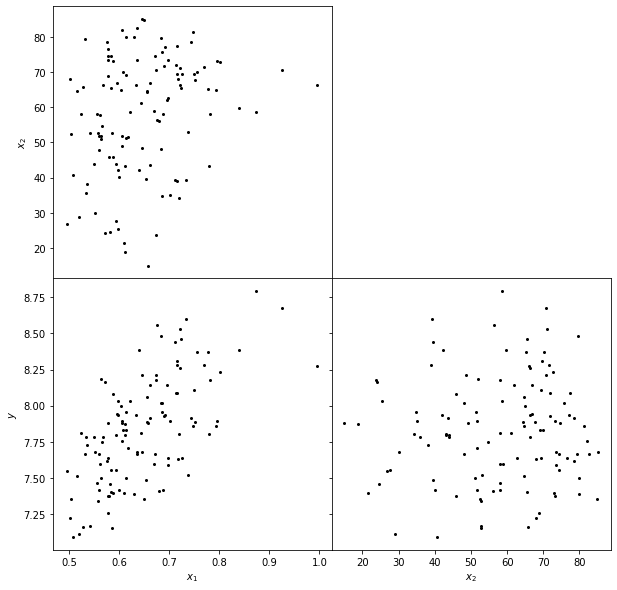

In [33]:
# print(X_true)

fig, axes = plt.subplots(2, 2, figsize=(5*(ndim-2), 5*(ndim-2)))

pointsize=4

# Make the plots look nicer...
ax = axes[0, 1]
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])

ax = axes[0, 0]
ax.scatter(X[:,0],X[:,1],c="black",s=pointsize)
ax.set_ylabel("$x_2$")
ax.set_xticklabels([])
ax = axes[1, 0]
ax.scatter(X[:,0],X[:,2],c="black",s=pointsize)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$y$")
ax = axes[1, 1]
ax.scatter(X[:,1],X[:,2],c="black",s=pointsize)
ax.set_xlabel("$x_2$")
ax.set_yticklabels([])
fig.subplots_adjust(wspace=0, hspace=0)
# plt.savefig("True_Stuff.png",dpi=100)
plt.show()

In [37]:
m_guess = [2.59,-0.001] # guesses for m1, m2, ... mn
b_guess = 6.1757 # guess for b
lambda_guess = 0.28 # guess for ln(f)

Running the MCMC

In [38]:
nwalkers = 64 # experiment with this
stepnum = 10**6 # number of steps
burnin = 0.05*stepnum # length of burn-in

In [39]:
# Run the MCMC.
sampler_D = emcee.EnsembleSampler(nwalkers, ndim, log_prob_D)
p0 = np.append(m_guess, [b_guess, np.log(lambda_guess)])
p0 = p0 + 1e-4 * np.random.randn(nwalkers, len(p0))
pos, _, _ = sampler_D.run_mcmc(p0, burnin)
sampler_D.reset()
sampler_D.run_mcmc(pos, stepnum,progress=True)
samples_D = sampler_D.flatchain

tau = sampler_D.get_autocorr_time(c=ndim)
nsamples = len(samples_D)
for i in range(ndim):
    print("{0:.0f} independent samples of ".format(nsamples / tau[i])+param_labels1[i])

/Users/sean/anaconda3/lib/python3.6/site-packages/emcee-3.0.0-py3.6.egg/emcee/ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,
100%|██████████| 1000000/1000000 [1:00:07<00:00, 277.19it/s]


1334469 independent samples of m_1
1337756 independent samples of b
1330084 independent samples of \ln\lambda


IndexError: list index out of range

In [50]:
for i in range(ndim): # print out the converged values
    mcmc = np.percentile(samples_D[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], param_labels1[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Visualizing the chains and the density plots

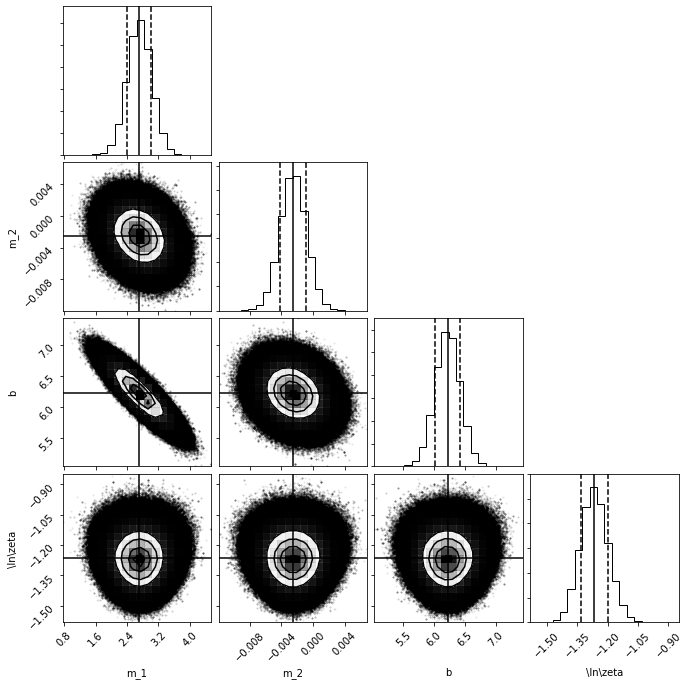

In [51]:
plot_corner_full2(samples_D,param_labels1)

In [ ]:
plot_samples_full(sampler_D, ndim, param_labels1)

In [162]:
# # Making the uncertainty matrix
# S = np.zeros((N, 3, 3))
# for n in range(N): # for each data point
#     for (i,j) in product(range(3),range(3)):
#         if i==j: # if along the diagonals, find the variance of X[n][i] - done?
#             S[n][i][i]=variance(X[:,i],n)
#         else: # else, find the covariance between X[n][i] and X[n][j] - done?
#             S[n][i][j]=cov(X[:,i],X[:,j],n) 

# X_tiny = X/X.sum(0) # normalizing each vector column to sum each column to 1

# X_normalpls = X_tiny-X_tiny.mean(0) 

# print(np.matmul(X_normalpls.T,X_normalpls)/116)

# X_normalpls

# S = np.zeros((N, 3, 3))
# for n in range(N): # for each data point
#     for (i,j) in product(range(3),range(3)):
#         if i==j: # if along the diagonals, find the variance of X[n][i] - done?
#             S[n][i][i]=variance(X_normalpls[:,i],n)
#         else: # else, find the covariance between X[n][i] and X[n][j] - done?
#             S[n][i][j]=cov(X_normalpls[:,i],X_normalpls[:,j],n) 

# X_norm.sum(0)